### imports

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys

### Import and process the data

In [2]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=";")
data = data[data["total sulfur dioxide"] < 200]  # drop a few outliers

# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop("quality")
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

### A function to process the data by quality metric



In [3]:
def createAdataset(qualThreshold):

    data["boolQuality"] = 0
    tmp = (data["quality"] > qualThreshold).astype(int)
    data["boolQuality"] = tmp

    # convert from pandas dataframe to tensor
    dataT = torch.tensor(data[cols2zscore].values).float()
    labels = torch.tensor(data["boolQuality"].values).float()
    labels = labels[:, None]  # transform to matrix

    #  split the data
    train_data, test_data, train_labels, test_labels = train_test_split(dataT, labels, test_size=0.1)

    # then convert them into PyTorch Datasets (note: already converted to tensors)
    train_data = TensorDataset(train_data, train_labels)
    test_data = TensorDataset(test_data, test_labels)

    # finally, translate into dataloader objects
    batchsize = 8
    train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

    return train_loader, test_loader

In [4]:
# test the dataset and the number of samples
train_loader, test_loader = createAdataset(5)
qualityRatings = train_loader.dataset.tensors[1].detach()
print("%s low-rated wines" % torch.sum(qualityRatings == 0).item())
print("%s high-rated wines" % torch.sum(qualityRatings == 1).item())

657 low-rated wines
780 high-rated wines


### DL model and a function to train it

In [5]:
class ANNwine(nn.Module):
    def __init__(self):
        super().__init__()

        ### input layer
        self.input = nn.Linear(11, 16)

        ### hidden layers
        self.fc1 = nn.Linear(16, 32)
        self.fc2 = nn.Linear(32, 32)

        ### output layer
        self.output = nn.Linear(32, 1)

    # forward pass
    def forward(self, x):
        x = F.leaky_relu(self.input(x))
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        return self.output(x)

In [9]:
numepochs = 100


def trainTheModel(winenet):

    lossfun = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(winenet.parameters(), lr=0.001)

    # initialize losses
    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    # loop over epochs
    for epochi in range(numepochs):

        # loop over training data batches
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            # forward pass and loss
            yHat = winenet(X)
            loss = lossfun(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute training accuracy for this batch
            batchAcc.append(100 * torch.mean(((yHat > 0) == y).float()).item())

        trainAcc.append(np.mean(batchAcc))
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = winenet(X)
        testAcc.append(100 * torch.mean(((yHat > 0) == y).float()).item())

        sys.stdout.write("\rEpoch %d: Train accuracy %f, Test accuracy %f" % (epochi, trainAcc[-1], testAcc[-1]))

    return trainAcc, testAcc, losses

In [10]:
# create the data
train_loader, test_loader = createAdataset(5)

# create a model and train it
winenet = ANNwine()
trainAcc, testAcc, losses = trainTheModel(winenet)

# compute accuracy per quality type
X, y = next(iter(test_loader))
yHat = winenet(X)
itemAccuracy = ((yHat > 0) == y).float()

perQualAcc = [
    100 * torch.mean(itemAccuracy[y == 0]),
    100 * torch.mean(itemAccuracy[y == 1]),
]
print()
print("Accuracy for low-rated wines: %.2f%%" % perQualAcc[0].item())
print("Accuracy for high-rated wines: %.2f%%" % perQualAcc[1].item())

Epoch 99: Train accuracy 91.899441, Test accuracy 76.249999Accuracy for low-rated wines: 71.62%
Accuracy for high-rated wines: 80.23%


### run the experiment

Epoch 99: Train accuracy 97.067039, Test accuracy 83.749998

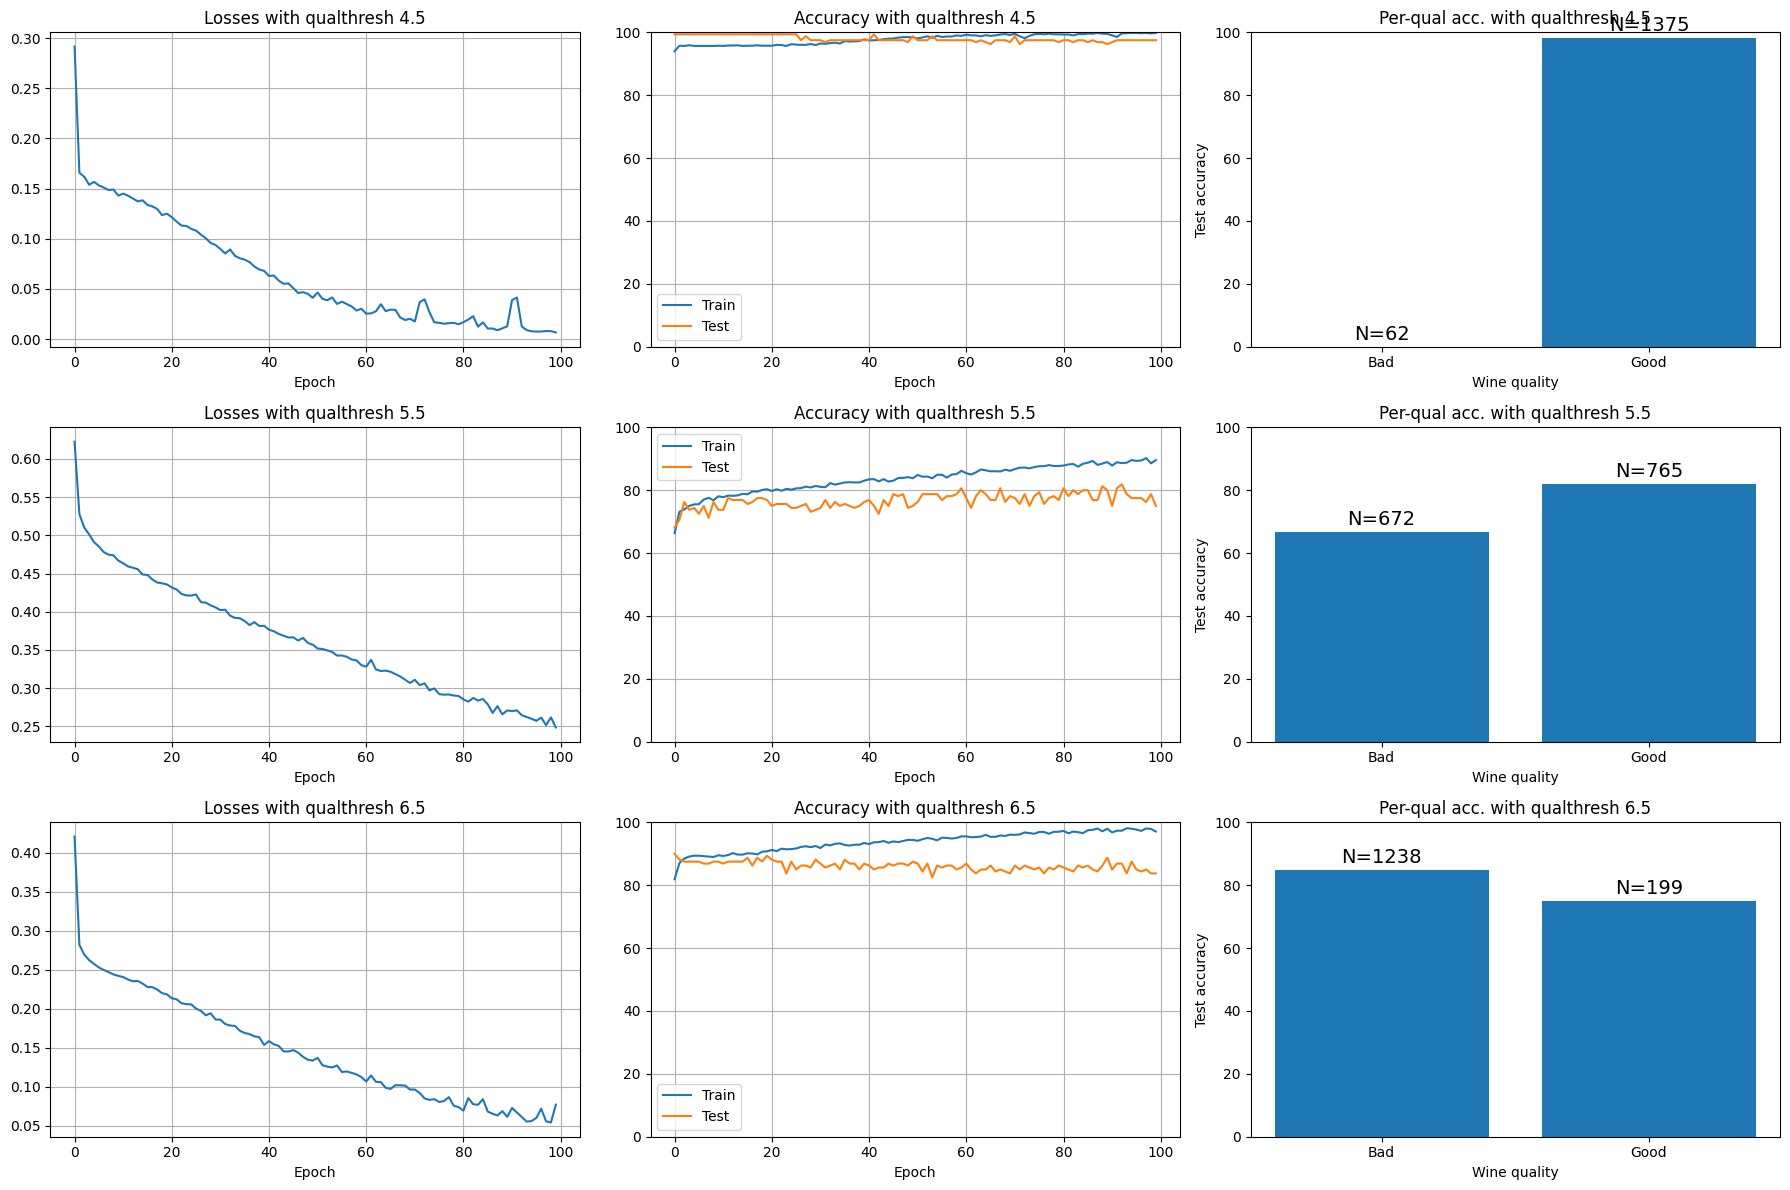

In [12]:
fig, ax = plt.subplots(3, 3, figsize=(18, 12))

# the quality thresholds
qualityThresholds = [4, 5, 6]

for quali in range(len(qualityThresholds)):

    # create the data and model, and train it
    train_loader, test_loader = createAdataset(qualityThresholds[quali])
    winenet = ANNwine()
    trainAcc, testAcc, losses = trainTheModel(winenet)

    # compute accuracy per quality type
    X, y = next(iter(test_loader))
    itemAccuracy = ((winenet(X) > 0) == y).float()
    perQualAcc = [
        100 * torch.mean(itemAccuracy[y == 0]),
        100 * torch.mean(itemAccuracy[y == 1]),
    ]

    # plot losses
    ax[quali, 0].plot(losses)
    ax[quali, 0].set_title(
        "Losses with qualthresh " + str(qualityThresholds[quali] + 0.5)
    )
    ax[quali, 0].set_xlabel("Epoch")
    ax[quali, 0].grid()

    # plot overall accuracy
    ax[quali, 1].plot(trainAcc, label="Train")
    ax[quali, 1].plot(testAcc, label="Test")
    ax[quali, 1].set_title(
        "Accuracy with qualthresh " + str(qualityThresholds[quali] + 0.5)
    )
    ax[quali, 1].legend()
    ax[quali, 1].set_xlabel("Epoch")
    ax[quali, 1].set_ylim([0, 100])
    ax[quali, 1].grid()

    # plot the per-quality accuracy
    bh = ax[quali, 2].bar(["Bad", "Good"], perQualAcc)
    ax[quali, 2].set_ylim([0, 100])
    ax[quali, 2].set_xlabel("Wine quality")
    ax[quali, 2].set_ylabel("Test accuracy")
    ax[quali, 2].set_title(
        "Per-qual acc. with qualthresh " + str(qualityThresholds[quali] + 0.5)
    )

    # print the counts on top of each bar
    for i, r in enumerate(bh):
        N = torch.sum(train_loader.dataset.tensors[1] == i).item()
        ax[quali, 2].text(
            r.get_x() + r.get_width() / 2,
            r.get_height() + 1,
            "N=%s" % N,
            ha="center",
            va="bottom",
            fontsize=14,
        )

plt.tight_layout()
plt.show()